<a href="https://colab.research.google.com/github/krutim12/nz_electricity_demand_forecasting/blob/main/nz_electricity_demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
path = "/Demand_trends.csv"

In [21]:
# Find where the real header starts
with open(path, "r", encoding="utf-8", errors="replace") as f:
    lines = f.readlines()

header_idx = None
for i, line in enumerate(lines):
    if "Period start" in line and "Period end" in line:
        header_idx = i
        break

In [22]:
df = pd.read_csv(path, skiprows=header_idx)
df.columns = [c.strip() for c in df.columns]

df["Period start"] = pd.to_datetime(df["Period start"], errors="coerce")
df["Demand (GWh)"] = pd.to_numeric(df["Demand (GWh)"], errors="coerce")
df = df.dropna(subset=["Period start", "Demand (GWh)"])

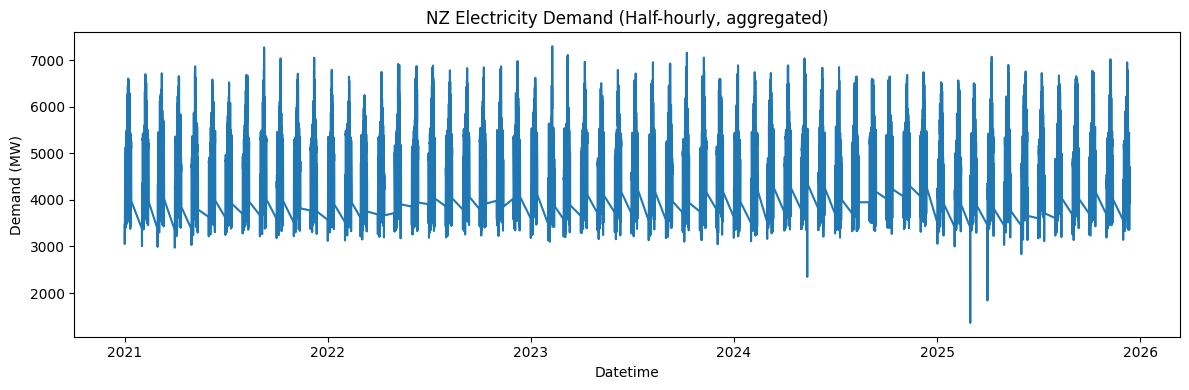

,Period start,Demand (GWh),Demand (MW)
0,2021-01-01 00:00:00,1.734,3468.0
1,2021-01-01 00:30:00,1.696,3392.0
2,2021-01-01 01:00:00,1.659,3318.0
3,2021-01-01 01:30:00,1.615,3230.0
4,2021-01-01 02:00:00,1.585,3170.0


In [23]:
# Aggregate all zones to NZ total
nz = df.groupby("Period start", as_index=False)["Demand (GWh)"].sum()
nz["Demand (MW)"] = nz["Demand (GWh)"] * 2000

plt.figure(figsize=(12,4))
plt.plot(nz["Period start"], nz["Demand (MW)"])
plt.title("NZ Electricity Demand (Half-hourly, aggregated)")
plt.xlabel("Datetime")
plt.ylabel("Demand (MW)")
plt.tight_layout()
plt.show()

nz.head()

/tmp/ipython-input-1567969529.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = nz_ts["Demand (MW)"].resample("H").mean()


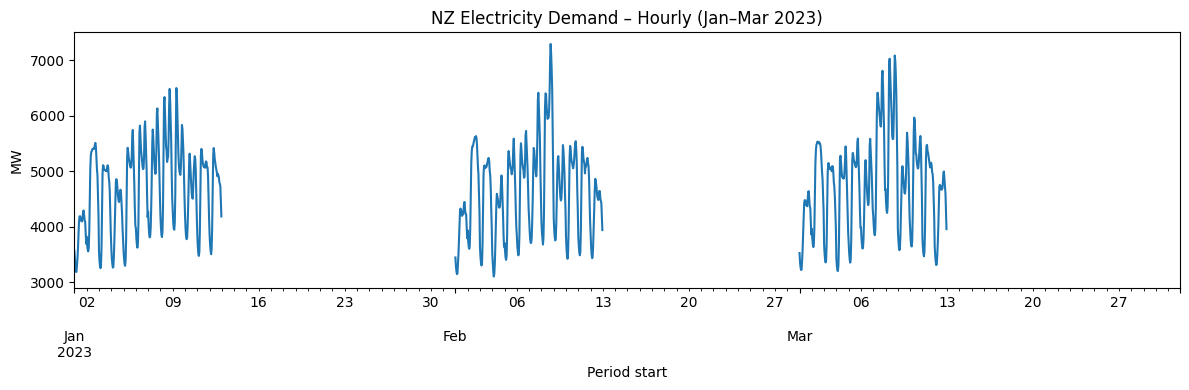

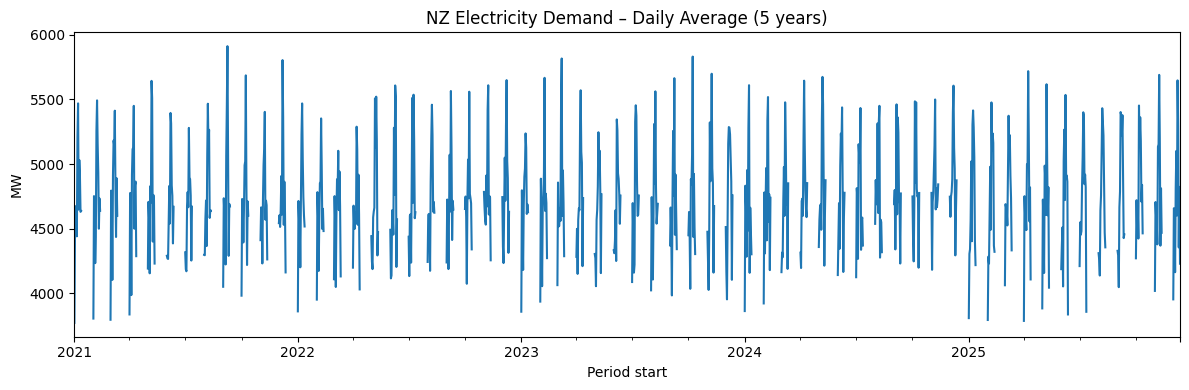

,Demand (MW)
Period start,
2021-01-01,3771.708333
2021-01-02,4471.583333
2021-01-03,4636.250000
2021-01-04,4677.083333
2021-01-05,4441.125000


In [24]:
# Set datetime index
nz_ts = nz.set_index("Period start")

# Hourly demand
hourly = nz_ts["Demand (MW)"].resample("H").mean()

# Daily demand
daily = nz_ts["Demand (MW)"].resample("D").mean()

# Plot hourly (short window)
plt.figure(figsize=(12,4))
hourly["2023-01":"2023-03"].plot()
plt.title("NZ Electricity Demand – Hourly (Jan–Mar 2023)")
plt.ylabel("MW")
plt.tight_layout()
plt.show()

# Plot daily (full period)
plt.figure(figsize=(12,4))
daily.plot()
plt.title("NZ Electricity Demand – Daily Average (5 years)")
plt.ylabel("MW")
plt.tight_layout()
plt.show()

daily.head()


The exploratory analysis reveals clear and consistent seasonal patterns in New Zealand electricity demand. At an hourly level, demand exhibits strong intraday seasonality, with pronounced peaks occurring in the morning and evening, reflecting typical residential and commercial activity cycles. When aggregated to daily averages, a repeating weekly pattern is evident, with higher demand on weekdays compared to weekends. Over the full five-year period, demand remains relatively stable with no evidence of explosive long-term growth or decline, indicating that short-term and seasonal factors dominate overall demand variation. These characteristics suggest that electricity demand is well-suited to time-series forecasting approaches that incorporate calendar effects and lagged demand features.

The code block below splits the daily electricity demand data into a training period and a testing period, using the most recent six months as unseen future data. This allows us to evaluate forecasting models in a realistic, time-aware manner.

Train period: 2021-01-01 00:00:00 to 2025-06-12 00:00:00
Test period: 2025-06-13 00:00:00 to 2025-12-12 00:00:00


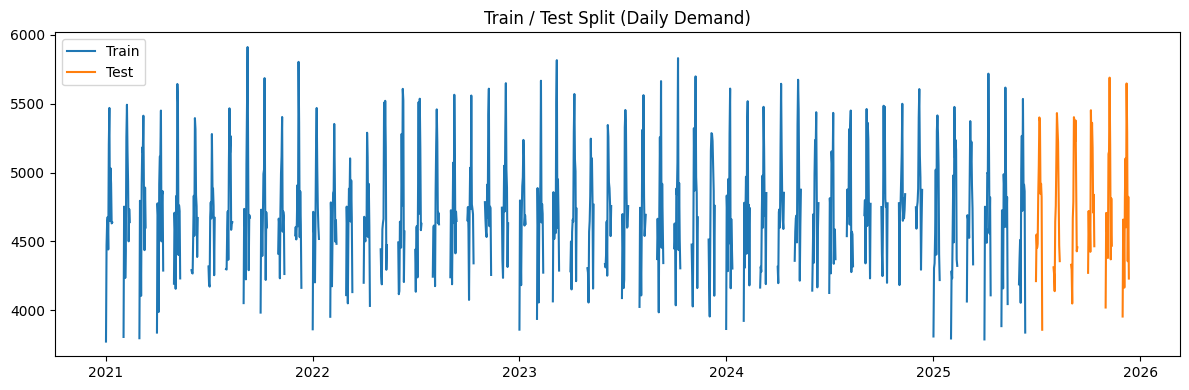

In [25]:
# Train-test split (last 6 months as test)
split_date = daily.index.max() - pd.DateOffset(months=6) # finds the date that is 6 months before the last available observation.

train = daily[daily.index <= split_date] #up to and including the split date
test = daily[daily.index > split_date]

print("Train period:", train.index.min(), "to", train.index.max()) #sanity check
print("Test period:", test.index.min(), "to", test.index.max())

plt.figure(figsize=(12,4))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.title("Train / Test Split (Daily Demand)")
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Naive forecast: yesterday = today (baseline)
naive_forecast = test.shift(1)

# Combine actual + forecast, then drop any rows with NaN
eval_df = pd.concat([test.rename("actual"), naive_forecast.rename("pred")], axis=1).dropna()

mae_naive = mean_absolute_error(eval_df["actual"], eval_df["pred"])
rmse_naive = np.sqrt(mean_squared_error(eval_df["actual"], eval_df["pred"]))

mae_naive, rmse_naive


(346.518308080808, np.float64(436.1053785793058))

A naive baseline forecast using the previous day’s demand achieved an MAE of around 350 MW. This indicates relatively stable day-to-day demand, but also highlights the need for models that better capture weekly and seasonal patterns.

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Seasonal naive forecast: same day last week
seasonal_forecast = test.shift(7)

# Combine actual + forecast, then drop any rows with NaN
eval_seasonal = pd.concat(
    [test.rename("actual"), seasonal_forecast.rename("pred")],
    axis=1
).dropna()

mae_seasonal = mean_absolute_error(eval_seasonal["actual"], eval_seasonal["pred"])
rmse_seasonal = np.sqrt(mean_squared_error(eval_seasonal["actual"], eval_seasonal["pred"]))

mae_seasonal, rmse_seasonal


(614.5277777777778, np.float64(751.2560997626279))

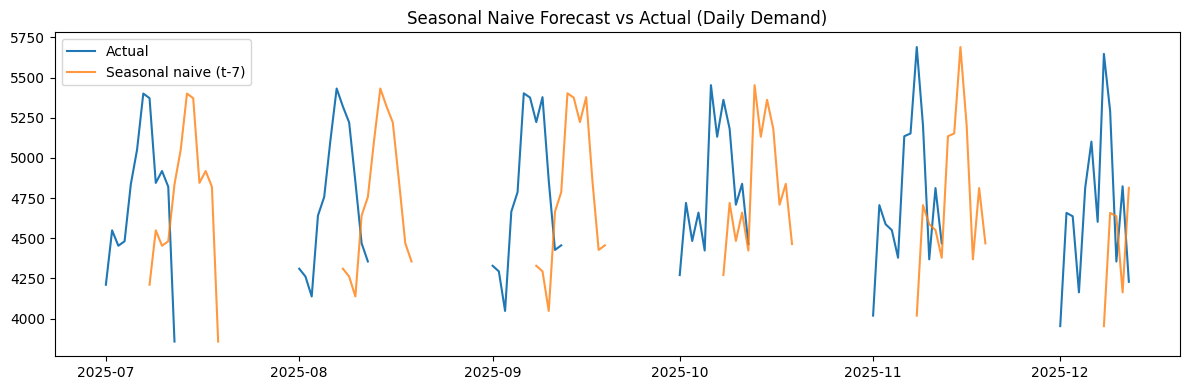

In [28]:
plt.figure(figsize=(12,4))
plt.plot(test, label="Actual")
plt.plot(seasonal_forecast, label="Seasonal naive (t-7)", alpha=0.8)
plt.title("Seasonal Naive Forecast vs Actual (Daily Demand)")
plt.legend()
plt.tight_layout()
plt.show()


Although weekly seasonality is visible in electricity demand, the seasonal naive model fails to capture week-to-week shifts in demand levels. As a result, forecasts based solely on demand from the same weekday in the previous week frequently lag behind the actual series, leading to higher forecast errors compared to a simple lag-1 baseline.

In [29]:
df_model = daily.to_frame(name="demand") #converts daily (time series) to dataframe

df_model.head()


,demand
Period start,
2021-01-01,3771.708333
2021-01-02,4471.583333
2021-01-03,4636.250000
2021-01-04,4677.083333
2021-01-05,4441.125000


In [30]:
df_model["lag_1"] = df_model["demand"].shift(1) #yesterday’s demand
df_model["lag_7"] = df_model["demand"].shift(7) #same weekday last week

df_model.head(10)


,demand,lag_1,lag_7
Period start,,,
2021-01-01,3771.708333,NaN,NaN
2021-01-02,4471.583333,3771.708333,NaN
2021-01-03,4636.250000,4471.583333,NaN
2021-01-04,4677.083333,4636.250000,NaN
2021-01-05,4441.125000,4677.083333,NaN
2021-01-06,5206.666667,4441.125000,NaN
2021-01-07,5469.625000,5206.666667,NaN
2021-01-08,4647.833333,5469.625000,3771.708333
2021-01-09,5031.375000,4647.833333,4471.583333


In [31]:
#calander features
df_model["day_of_week"] = df_model.index.dayofweek # 0 = monday, 6 = sunday
df_model["month"] = df_model.index.month # Captures seasonal demand patterns across the year.

df_model.head()


,demand,lag_1,lag_7,day_of_week,month
Period start,,,,,
2021-01-01,3771.708333,NaN,NaN,4,1
2021-01-02,4471.583333,3771.708333,NaN,5,1
2021-01-03,4636.250000,4471.583333,NaN,6,1
2021-01-04,4677.083333,4636.250000,NaN,0,1
2021-01-05,4441.125000,4677.083333,NaN,1,1


In [32]:
df_model = df_model.dropna()

df_model.isna().sum()


,0
demand,0
lag_1,0
lag_7,0
day_of_week,0
month,0


In [33]:
train_reg = df_model.loc[:train.index[-1]] #avoiding data leakage
test_reg = df_model.loc[test.index[0]:]

train_reg.shape, test_reg.shape


((270, 5), (30, 5))

In [34]:
features = ["lag_1", "lag_7", "day_of_week", "month"]

X_train = train_reg[features]
y_train = train_reg["demand"]

X_test = test_reg[features]
y_test = test_reg["demand"]


In [35]:
#fitting a linear regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [36]:
y_pred = model.predict(X_test)


In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_reg = mean_absolute_error(y_test, y_pred)
rmse_reg = np.sqrt(mean_squared_error(y_test, y_pred))

mae_reg, rmse_reg


(290.76625172122147, np.float64(332.15645611890403))

A linear regression model incorporating lagged demand and calendar features achieved an MAE of approximately 291 MW, outperforming both a naive lag-1 baseline and a seasonal naive model. This improvement highlights the importance of combining short-term persistence with weekly and seasonal effects when forecasting electricity demand. The results demonstrate that relatively simple, interpretable models can provide accurate and robust forecasts when appropriate time-series features are engineered.

In [38]:
import pandas as pd

coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": model.coef_
}).sort_values(by="coefficient", ascending=False)

coef_df


,feature,coefficient
3,month,10.323168
0,lag_1,0.231765
1,lag_7,-0.617323
2,day_of_week,-3.263633


Linear regression results indicate that electricity demand exhibits strong short-term persistence, with yesterday’s demand being the dominant predictor. Weekly effects provide additional explanatory power when conditioned on recent demand, while calendar variables such as day of week and month capture systematic behavioural and seasonal patterns. The combination of lagged demand and calendar features significantly improves forecasting accuracy over naive baselines.

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Use the SAME train/test split as linear regression
X_train = train_reg[features]
y_train = train_reg["demand"]

X_test = test_reg[features]
y_test = test_reg["demand"]

# Random Forest model
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

# Fit model
rf.fit(X_train, y_train)

# Predictions
rf_pred = rf.predict(X_test)

# Evaluation
mae_rf = mean_absolute_error(y_test, rf_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))

mae_rf, rmse_rf


(253.97988835055932, np.float64(312.7261482895433))

In [41]:
feature_importance = pd.DataFrame({
    "feature": features,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance

,feature,importance
1,lag_7,0.492169
0,lag_1,0.337903
3,month,0.098220
2,day_of_week,0.071707


A Random Forest model was trained using lagged demand and calendar features to capture non-linear relationships in electricity demand. The model achieved the lowest forecasting error (MAE ≈ 254 MW, RMSE ≈ 313 MW), outperforming both naive baselines and linear regression. Feature importance analysis indicates that demand from the same day in the previous week (lag 7) is the dominant predictor, followed by demand from the previous day (lag 1), confirming strong weekly and short-term persistence in electricity usage. Calendar features such as month and day of week contribute additional seasonal context but play a secondary role.

In [42]:
pd.DataFrame({
    "Model": ["Naive", "Seasonal Naive", "Linear Regression", "Random Forest"],
    "MAE (MW)": [mae_naive, mae_seasonal, mae_reg, mae_rf],
    "RMSE (MW)": [rmse_naive, rmse_seasonal, rmse_reg, rmse_rf]
})


,Model,MAE (MW),RMSE (MW)
0,Naive,346.518308,436.105379
1,Seasonal Naive,614.527778,751.256100
2,Linear Regression,290.766252,332.156456
3,Random Forest,253.979888,312.726148


Forecasting performance improves substantially as models incorporate more temporal information and flexibility. A simple naive baseline achieved an MAE of 347 MW, while a seasonal naive model performed poorly, indicating that weekly seasonality alone is insufficient to capture demand variability. Introducing lagged and calendar features via linear regression reduced the MAE to 291 MW, demonstrating the value of combining short-term persistence with seasonal structure. The Random Forest model achieved the lowest error (MAE ≈ 254 MW, RMSE ≈ 313 MW), reflecting its ability to model non-linear relationships and interactions between lagged demand and calendar effects. Overall, results highlight that electricity demand is driven by both short-term and weekly dynamics, which are best captured using flexible machine learning models.